In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [2]:
import os
import random
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/transaction-yes-no.zip -d /content/

In [5]:
# Paths
DATASET_DIR = "/content/transaction-yes-no/"
TRAIN_DIR = "/content/transaction-yes-no/train/"
TEST_DIR = "/content/transaction-yes-no/test/"

In [6]:
MODEL_SAVE_DIR = "/content/saved_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [7]:
for split_dir in [TRAIN_DIR, TEST_DIR]:
    for class_name in ['Yes', 'No']:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

In [8]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('jpg', 'jpeg', 'png'))])

In [9]:
# Split data function
def split_data(source_dir, train_dir, test_dir, train_ratio=0.8):
    for class_name in ['Yes', 'No']:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Split data
split_data(DATASET_DIR, TRAIN_DIR, TEST_DIR, train_ratio=0.8)

In [10]:
# Data augmentation function
def augment_class(class_dir, target_count):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)

    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_format='jpeg'):
            current_count += 1
            if current_count >= target_count:
                break

In [11]:
# Undersampling for majority class
def undersample_class(class_dir, target_count):
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(images)

    for img_name in images[target_count:]:
        img_path = os.path.join(class_dir, img_name)
        os.remove(img_path)

In [12]:
# Balance dataset
train_yes_dir = os.path.join(TRAIN_DIR, 'Yes')
train_no_dir = os.path.join(TRAIN_DIR, 'No')

yes_count = count_images(train_yes_dir)
no_count = count_images(train_no_dir)

print(f"Before balancing: Yes = {yes_count}, No = {no_count}")

Before balancing: Yes = 1121, No = 2836


In [13]:
target_count = max(yes_count, no_count)
augment_class(train_yes_dir, target_count)
undersample_class(train_no_dir, target_count)

yes_count = count_images(train_yes_dir)
no_count = count_images(train_no_dir)

print(f"After balancing: Yes = {yes_count}, No = {no_count}")

After balancing: Yes = 2698, No = 2836


In [14]:
# Data generators
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [15]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5534 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [16]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [17]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)

In [29]:
# # Define model with ResNet50 as backbone
# with tf.distribute.get_strategy().scope():
#     base_model_resnet = ResNet50(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
#     base_model_resnet.trainable = False
#     for layer in base_model_resnet.layers[:20]:
#         layer.trainable = True


#     model_resnet = Sequential([
#         base_model_resnet,
#         GlobalAveragePooling2D(),
#         Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(1, activation='sigmoid')
#     ])

#     model_resnet.compile(
#         optimizer=Adam(learning_rate=0.0001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )

#
# model_resnet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,859,073 (91.02 MB)

 Trainable params: 372,673 (1.42 MB)

 Non-trainable params: 23,486,400 (89.59 MB)

In [30]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU instead.")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

with strategy.scope():
    base_model_resnet = ResNet50(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
    base_model_resnet.trainable = False

    model_resnetrn = Sequential([
        base_model_resnet,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_resnetrn.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
model_resnetrn.summary()

Not connected to a TPU runtime. Using CPU/GPU instead.
REPLICAS:  1


In [21]:
# from tensorflow.keras.layers import BatchNormalization

# with tf.distribute.get_strategy().scope():
#     base_model_mobilenet = MobileNet(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
#     base_model_mobilenet.trainable = False
#     for layer in base_model_mobilenet.layers[:50]:
#         layer.trainable = True

#     model_mobilenet = Sequential([
#         base_model_mobilenet,
#         BatchNormalization(),
#         GlobalAveragePooling2D(),
#         Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(1, activation='sigmoid')
#         ])


#     model_mobilenet.compile(
#         optimizer=Adam(learning_rate=0.0001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )

#
# model_mobilenet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372,481 (12.86 MB)

 Trainable params: 684,097 (2.61 MB)

 Non-trainable params: 2,688,384 (10.26 MB)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train model
EPOCHS = 50

In [31]:
history_resnetrn = model_resnetrn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# ResNet50 model
resnet_model_path = os.path.join(MODEL_SAVE_DIR, 'resnetrn_model.h5')
model_resnetrn.save(resnet_model_path)
print(f"ResNet50 model saved at {resnet_model_path}")

Epoch 1/50
 66/173 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.5850 - loss: 1.1171

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - accuracy: 0.6251 - loss: 1.0181 - val_accuracy: 0.7164 - val_loss: 0.7459 - learning_rate: 1.0000e-04
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.7407 - loss: 0.6896 - val_accuracy: 0.7326 - val_loss: 0.6364 - learning_rate: 1.0000e-04
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.7855 - loss: 0.5864 - val_accuracy: 0.8214 - val_loss: 0.5340 - learning_rate: 1.0000e-04
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.7909 - loss: 0.5539 - val_accuracy: 0.8163 - val_loss: 0.4966 - learning_rate: 1.0000e-04
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.8117 - loss: 0.5207 - val_accuracy: 0.8073 - val_loss: 0.4882 - learning_rate: 1.0000e-04
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.8204 - loss: 0.5025 - val_accuracy: 0.7760 - val_loss: 0.5270 - learning_rate: 1.0000e-04
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - 

ResNet50 model saved at /content/saved_models/resnetrn_model.h5


In [24]:
#
# history_mobilenet = model_mobilenet.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=test_generator,
#     callbacks=[early_stopping, reduce_lr],
#     class_weight=class_weights
# )

# # Save MobileNet model
# mobilenet_model_path = os.path.join(MODEL_SAVE_DIR, 'mobilenet_model.h5')
# model_mobilenet.save(mobilenet_model_path)
# print(f"MobileNet model saved at {mobilenet_model_path}")

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 64s 248ms/step - accuracy: 0.7902 - loss: 0.7532 - val_accuracy: 0.8668 - val_loss: 0.5931 - learning_rate: 1.0000e-04
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.9234 - loss: 0.5201 - val_accuracy: 0.9233 - val_loss: 0.4837 - learning_rate: 1.0000e-04
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.9472 - loss: 0.4428 - val_accuracy: 0.9435 - val_loss: 0.4264 - learning_rate: 1.0000e-04
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.9693 - loss: 0.3858 - val_accuracy: 0.9475 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.9782 - loss: 0.3550 - val_accuracy: 0.9586 - val_loss: 0.3842 - learning_rate: 1.0000e-04
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.9821 - loss: 0.3345 - val_accuracy: 0.9637 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 16

MobileNet model saved at /content/saved_models/mobilenet_model.h5


In [32]:
#Evaluating ResNet50 model
y_pred_prob_resnet = model_resnetrn.predict(test_generator)
y_pred_resnet = (y_pred_prob_resnet > 0.5).astype('int32')
print("\nResNet50 Classification Report:\n", classification_report(test_generator.classes, y_pred_resnet))
roc_auc_resnet = roc_auc_score(test_generator.classes, y_pred_prob_resnet)
print(f"ResNet50 ROC-AUC Score: {roc_auc_resnet:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step

ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       710
           1       0.34      0.28      0.31       281

    accuracy                           0.64       991
   macro avg       0.54      0.53      0.53       991
weighted avg       0.62      0.64      0.63       991

ResNet50 ROC-AUC Score: 0.5490


In [26]:
# Evaluate MobileNet model
# y_pred_prob_mobilenet = model_mobilenet.predict(test_generator)
# y_pred_mobilenet = (y_pred_prob_mobilenet > 0.5).astype('int32')
# print("\nMobileNet Classification Report:\n", classification_report(test_generator.classes, y_pred_mobilenet))
# roc_auc_mobilenet = roc_auc_score(test_generator.classes, y_pred_prob_mobilenet)
# print(f"MobileNet ROC-AUC Score: {roc_auc_mobilenet:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 439ms/step

MobileNet Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       710
           1       0.28      0.28      0.28       281

    accuracy                           0.59       991
   macro avg       0.50      0.50      0.50       991
weighted avg       0.59      0.59      0.59       991

MobileNet ROC-AUC Score: 0.4954


In [33]:
from sklearn.metrics import accuracy_score

y_pred_prob_resnet = model_resnetrn.predict(test_generator)

# Converting probabilities to class labels
y_pred_resnet = (y_pred_prob_resnet > 0.5).astype('int32')

test_accuracy = accuracy_score(test_generator.classes, y_pred_resnet)
print(f"ResNet50 Test Accuracy: {test_accuracy:.4f}")

print("\nResNet50 Classification Report:\n", classification_report(test_generator.classes, y_pred_resnet))

roc_auc_resnet = roc_auc_score(test_generator.classes, y_pred_prob_resnet)
print(f"ResNet50 ROC-AUC Score: {roc_auc_resnet:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step
ResNet50 Test Accuracy: 0.6125

ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.74       710
           1       0.28      0.23      0.25       281

    accuracy                           0.61       991
   macro avg       0.50      0.50      0.49       991
weighted avg       0.59      0.61      0.60       991

ResNet50 ROC-AUC Score: 0.4967


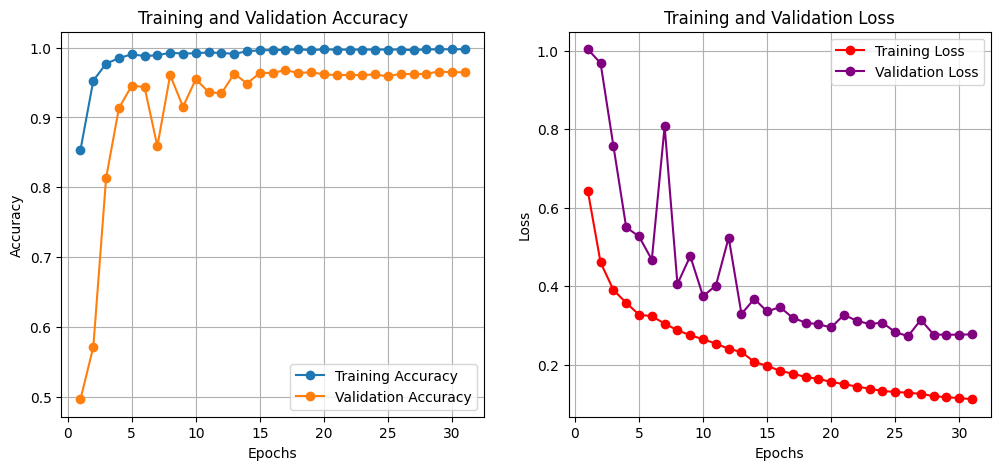

In [34]:
import matplotlib.pyplot as plt

acc = history_resnetrn.history['accuracy']
val_acc = history_resnetrn.history['val_accuracy']
loss = history_resnetrn.history['loss']
val_loss = history_resnetrn.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
# Example: Load saved models and use for predictions
# resnet_loaded = load_model(resnet_model_path)
# mobilenet_loaded = load_model(mobilenet_model_path)

# sample_image_path = os.path.join(TEST_DIR, 'Yes', os.listdir(os.path.join(TEST_DIR, 'Yes'))[0])
# sample_image = Image.open(sample_image_path).resize(IMG_SIZE).convert('RGB')
# sample_array = np.expand_dims(np.array(sample_image) / 255.0, axis=0)

# resnet_prediction = resnet_loaded.predict(sample_array)
# mobilenet_prediction = mobilenet_loaded.predict(sample_array)

In [ ]:
# print(f"ResNet50 Prediction: {resnet_prediction[0][0]:.4f}")
# print(f"MobileNet Prediction: {mobilenet_prediction[0][0]:.4f}")

In [ ]:
# # Select best-performing model and save
# if roc_auc_resnet > roc_auc_mobilenet:
#     best_model = model_resnet
#     print("Best model: ResNet50")
# else:
#     best_model = model_mobilenet
#     print("Best model: MobileNet")

# best_model.save("/content/best_model.h5")

In [35]:
model_path = '/content/saved_models/resnetrn_model.h5'
model = load_model(model_path)

def build_tunable_model(hp):
    model = load_model(model_path)
    model.trainable = True

    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = dropout_rate

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [39]:

tuner = kt.Hyperband(
    build_tunable_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='/content/hyperparameter_tuning',
    project_name='resnet_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)



Trial 25 Complete [00h 04m 43s]
val_accuracy: 0.8678103089332581

Best val_accuracy So Far: 0.8748738765716553
Total elapsed time: 00h 55m 35s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
0.4               |0.35              |dropout_rate
0.002582          |6.0174e-05        |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round



Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.8405 - loss: 0.4366 - val_accuracy: 0.8416 - val_loss: 0.4781
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 226ms/step - accuracy: 0.8647 - loss: 0.3791 - val_accuracy: 0.7154 - val_loss: 0.6979
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 223ms/step - accuracy: 0.8690 - loss: 0.3486 - val_accuracy: 0.7982 - val_loss: 0.5527
Epoch 4/10
128/173 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.8771 - loss: 0.3352

KeyboardInterrupt: 

In [42]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

test_accuracy = best_model.evaluate(test_generator)
print(f"Best Model Test Accuracy: {test_accuracy[1]:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.8797 - loss: 0.3290
Best Model Test Accuracy: 0.8749


In [ ]:
# # Get the best model from the tuner
# best_tuned_model = tuner.get_best_models(num_models=1)[0]

# # Evaluate on the test set
# test_loss, test_acc = best_tuned_model.evaluate(test_generator)
# print(f"Test Accuracy: {test_acc:.4f}")

# # Get the predictions
# y_pred_prob_tuned = best_tuned_model.predict(test_generator)
# y_pred_tuned = (y_pred_prob_tuned > 0.5).astype('int32')

# # Classification report
# print("\nClassification Report:\n", classification_report(test_generator.classes, y_pred_tuned))

# # ROC-AUC score
# roc_auc_tuned = roc_auc_score(test_generator.classes, y_pred_prob_tuned)
# print(f"ROC-AUC Score: {roc_auc_tuned:.4f}")

In [45]:
!pip install tf2onnx

In [2]:
import tensorflow as tf
import keras

model = keras.models.load_model("/content/best_hypermodel.h5")

tf.saved_model.save(model, "rn_model")

!python3 -m tf2onnx.convert --saved-model rn_model --output best_hprn_model.onnx

2025-01-31 16:35:17.433079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738341317.453883   44418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738341317.460320   44418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-31 16:35:22,906 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-01-31 16:35:23.039930: W tensorflow/core/common_